# Regression Training Pipeline

This notebook implements a complete Graph Neural Network (GNN) pipeline for a 3-class classification task (`Low`, `Medium`, `High`).  It now includes additional metrics in hyperparameter tuning and enhanced model comparison visualizations.

## Table of Contents
1. [Environment & Setup](#step1)
2. [Model Definition](#step2)
3. [Evaluation Function](#step3)
4. [Hyperparameter Sweep (10-Fold CV)](#step4)
5. [Retraining & Validation (10-Fold CV)](#step5)
6. [Cross-Validation Results Visualization](#step6)
7. [Ensemble Averaging](#step7)
8. [Final Model Training & Test Evaluation](#step8)
9. [Baseline QSAR Comparison](#step9)

---

## Prerequisites
- PyTorch & PyTorch Geometric  
- scikit-learn  
- pandas, numpy, matplotlib  
- RDKit (only for feature extraction)  
- GPU recommended

Install requirements:
```bash
pip install torch torch-geometric scikit-learn pandas numpy matplotlib rdkit-pypi
```

---

<a id="step1"></a>
## Step 1: Environment & Setup
- Seed all random generators for reproducibility.  
- Define paths for data splits and output.  
- Detect GPU/CPU.

<a id="step2"></a>
## Step 2: Model Definition
Defines:
- `MPNNLayer`: message-passing with dropout support.  
- `MPNN`: stacks layers, global mean pool, and final linear head.

<a id="step3"></a>
## Step 3: Evaluation Function
`evaluate(model, loader)` returns concatenated logits and true labels.

<a id="step4"></a>
## Step 4: Hyperparameter Sweep (10-Fold CV)
**Updates:** Now tracks both **AUC-ROC** and **Balanced Accuracy** per fold.

- Grid search over `hidden_dim`, `dropout`, `lr`.  
- For each config, run 10-fold CV: train for 50 epochs, then evaluate validation set.
- Compute per-fold metrics:
  - **AUC-ROC** (one-vs-rest)
  - **Balanced Accuracy** (accounts for class imbalance)
- Record **mean ± std** for both metrics.
- Results DataFrame `sweep_df` now contains `mean_auc`, `std_auc`, `mean_balanced_acc`, and `std_balanced_acc`.

<a id="step5"></a>
## Step 5: Retraining & Validation (10-Fold CV)
- Retrain each fold with best hyperparameters and early stopping.  
- Save best model weights.  
- Compute per-fold classification metrics: accuracy, precision, recall, F1, AUC-ROC.  
- Save `crossval_summary.csv`.

<a id="step6"></a>
## Step 6: Cross-Validation Results Visualization
- Load `crossval_summary.csv`.  
- Plot bar charts for each metric across folds.  
- Print mean ± std.

<a id="step7"></a>
## Step 7: Ensemble Averaging
- Load fold checkpoints, run on test set, average logits.  
- Save `ensemble_preds.csv` (True vs. Pred).
- **Ensemble evaluation plots** include confusion matrix and per-class ROC curves.

<a id="step8"></a>
## Step 8: Final Model Training & Test Evaluation
- Merge all train+val folds, reserve 10% for validation.  
- Train final model with early stopping and LR scheduler.  
- Evaluate on hold-out test: accuracy, precision, recall, F1, AUC-ROC.
- Plot confusion matrix and per-class ROC curves.  
- Save `final_model_metrics.csv`, `final_confusion_matrix.png`, and `final_auc_roc.png`.


---

## Parameters & Extensions
- **Epochs:** 50 for CV, 100 for final training  
- **Patience:** 10 for early stopping  
- **LR Scheduler:** `ReduceLROnPlateau` on validation loss  





## 1. Imports and Setup

In [2]:
import torch
from torch_geometric.loader import DataLoader
import torch.nn.functional as F
from torch.nn import Linear, Sequential, BatchNorm1d, ReLU, Dropout # For the multi-perceptron layer
from torch_geometric.nn import GINConv  # Load graph isomorphism network
from torch_geometric.nn import global_mean_pool, global_add_pool
from torch_geometric.data import Data
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, mean_squared_error
import numpy as np
import random
import os
import pandas as pd

## 2. Task and Reproducibility Setup

In [3]:
# Set seeds
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark     = False

# DataLoader seeding
from torch.utils.data import DataLoader as _DL
from torch.utils.data import get_worker_info

def seed_worker(worker_id):
    worker_seed = seed + worker_id
    np.random.seed(worker_seed)
    random.seed(worker_seed)

generator = torch.Generator()
generator.manual_seed(seed)

#task = "classification"  # or "regression"
task = "regression"  # or "classification"
num_classes = 3
class_names = {0: "Low", 1: "Medium", 2: "High"}
kfold = 10
base_path = f"../4_train_test_split/10fold_cv/{task}/"
results_dir = f"GIN_results/{task}_{kfold}fold/"
os.makedirs(results_dir, exist_ok=True)

## 3. Define GIN Model with Dropout Support

In [5]:
# 🧱 Define Model (GIN)
class GIN(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, dropout): # where "dim_h" is dimensionality of layer; number of features or neurons that layer processes
        super(GIN, self).__init__()
        self.dropout = dropout
        self.conv1 = GINConv( # design of the multilayer perceptron layer for the GINConv layer based on the paper (https://arxiv.org/pdf/1905.12265)
            Sequential(Linear(in_channels, hidden_channels),
                       BatchNorm1d(hidden_channels), ReLU(),
                       Linear(hidden_channels, hidden_channels), ReLU()))
        self.conv2 = GINConv(
            Sequential(Linear(hidden_channels, hidden_channels), BatchNorm1d(hidden_channels), ReLU(),
                       Linear(hidden_channels, hidden_channels), ReLU()))
        self.conv3 = GINConv(
            Sequential(Linear(hidden_channels, hidden_channels), BatchNorm1d(hidden_channels), ReLU(),
                       Linear(hidden_channels, hidden_channels), ReLU()))
        self.lin1 = Linear(hidden_channels*3, hidden_channels*3)
        self.lin2 = Linear(hidden_channels*3, out_channels)

    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch
        # Node embeddings
        h1 = self.conv1(x, edge_index) 
        h2 = self.conv2(h1, edge_index)
        h3 = self.conv3(h2, edge_index)

        # Graph level readout
        h1 = global_add_pool(h1, batch) 
        h2 = global_add_pool(h2, batch)
        h3 = global_add_pool(h3, batch)

        # Concatenate graph embeddings
        h = torch.cat((h1, h2, h3), dim=1)

        # Classifier
        h = self.lin1(h)
        h = h.relu()
        h = F.dropout(h, p=self.dropout, training=self.training)
        h = self.lin2(h)

        return h

# ## Step 4: Select Best Hyperparameters
# Use this section to manually define the best hyperparameters based on the sweep above.


In [8]:
from sklearn.metrics import (
    accuracy_score, precision_recall_fscore_support, roc_auc_score,
    confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc,
    mean_absolute_error, mean_squared_error, r2_score
)
from sklearn.preprocessing import label_binarize
import numpy as np

#10 fold cross-validation
task = "regression"

test_data = torch.load(f"../4_train_test_split/10fold_cv/{task}/{task}_test.pt")
average_score = 0

hidden_channels = [64, 128, 256]
dropouts    = [0.0, 0.2, 0.4]
lrs         = [1e-3, 5e-4, 1e-4]

results = []

for hd in hidden_channels:
    for dp in dropouts:
        for lr in lrs:
            print(f"\n🔧 Config: hidden_channels={hd}, dropout={dp}, lr={lr}")
            fold_metrics = []

            for fold_idx in range(10):
                #load data from fold_idx-th fold
                train_data = torch.load(f"../4_train_test_split/10fold_cv/{task}/{task}_train_fold{fold_idx}.pt")
                val_data = torch.load(f"../4_train_test_split/10fold_cv/{task}/{task}_val_fold{fold_idx}.pt")
                
                device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

                #initialize models
                if task == "classification":
                    num_classes = len(set([int(data.y.item()) for data in train_data]))
                    model = GIN(in_channels=train_data[0].x.size(1), hidden_channels=hd, out_channels=num_classes, dropout=dp).to(device)
                    criterion = torch.nn.CrossEntropyLoss()
                else:
                    model = GIN(in_channels=train_data[0].x.size(1), hidden_channels=hd, out_channels=1, dropout=dp).to(device)
                    criterion = torch.nn.MSELoss()
                
                opt = torch.optim.Adam(model.parameters(), lr=lr)

                # Initialize Data Loaders 
                tr = DataLoader(train_data, batch_size=32, shuffle=True,
                                worker_init_fn=seed_worker, generator=generator)
                vl = DataLoader(val_data, batch_size=32)

                # 📈 Evaluation
                def evaluate(model, loader):
                    model.eval()
                    preds, labels = [], []
                    with torch.no_grad():
                        for batch in loader:
                            batch = batch.to(device)
                            out = model(batch)
                            preds.append(out.cpu())
                            labels.append(batch.y.cpu())
                    return torch.cat(preds), torch.cat(labels)

                # Training loop
                for epoch in range(1, 51):
                    model.train()
                    for batch in tr:
                        batch = batch.to(device)
                        opt.zero_grad()
                        out = model(batch)
                        loss = F.mse_loss(out.squeeze(), batch.y)
                        loss.backward()
                        opt.step()
                # Validation
                preds, trues = evaluate(model, vl)
                y_true = trues.numpy()
                y_pred = preds.squeeze().numpy()
                r2 = r2_score(y_true, y_pred)
                fold_metrics.append(r2)

            # Record mean and std
            mean_r2 = np.mean(fold_metrics)
            std_r2  = np.std(fold_metrics)
            results.append((hd, dp, lr, mean_r2, std_r2))
            print(f"📊 R²: {mean_r2:.4f} ± {std_r2:.4f}")

# Compile results into DataFrame
sweep_df = pd.DataFrame(results,
                        columns=["hidden_dim", "dropout", "learning_rate", "mean_r2", "std_r2"])
# Display sorted by best performance
display(sweep_df.sort_values("mean_r2", ascending=False))
cv_df = pd.DataFrame(fold_metrics)

                




🔧 Config: hidden_channels=64, dropout=0.0, lr=0.001


KeyboardInterrupt: 

# ## Select best hyperparameters.

In [9]:
best_hidden_dim = 256
best_dropout = 0.0
best_lr = 0.001

# ## Step 5a: Retrain All Folds with Best Hyperparameters

In [10]:
from sklearn.metrics import (
    mean_absolute_error,
    mean_squared_error,
    r2_score
)
import pandas as pd

fold_metrics = []

for fold in range(10):
    print(f"\n🔁 Retraining Fold {fold+1}/10 with best hyperparameters")
    train_data = torch.load(os.path.join(base_path, f"{task}_train_fold{fold}.pt"))
    val_data   = torch.load(os.path.join(base_path, f"{task}_val_fold{fold}.pt"))

    model = GIN(train_data[0].x.size(1),
                 hidden_channels=best_hidden_dim,
                 out_channels=1,
                 dropout=best_dropout).to(device)
    
    optimizer = torch.optim.Adam(model.parameters(), lr=best_lr)
    train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
    val_loader   = DataLoader(val_data,   batch_size=32)

    best_val_loss = float('inf')
    patience = 0

    # Training loop with early stopping
    for epoch in range(1, 101):
        model.train()
        total_loss = 0
        for batch in train_loader:
            batch = batch.to(device)
            optimizer.zero_grad()
            out = model(batch).view(-1)
            target = batch.y.view(-1).float()
            loss = (F.mse_loss(out, target))
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        # Evaluate on validation
        preds, targets = evaluate(model, val_loader)
        val_loss = mean_squared_error(targets.numpy(), preds.numpy())

        print(f"Epoch {epoch:03d} | Train Loss: {total_loss/len(train_loader):.4f} | Val Loss: {val_loss:.4f}")

        # Save best
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience = 0
            torch.save(model.state_dict(),
                       os.path.join(results_dir, f"fold{fold+1}_model.pt"))
        else:
            patience += 1
            if patience >= 10:
                print("⏹️ Early stopping")
                break

    # --- After training this fold, compute metrics on its validation set ---
    preds_np = preds.squeeze().cpu().numpy()
    trues_np = targets.cpu().numpy()

    if task == "classification":
        from sklearn.metrics import (
            accuracy_score,
            precision_recall_fscore_support,
            roc_auc_score
        )
        y_true = trues_np.astype(int)
        y_probs = F.softmax(preds, dim=1).cpu().numpy()
        y_pred  = preds.argmax(dim=1).cpu().numpy()

        acc = accuracy_score(y_true, y_pred)
        precision, recall, f1, _ = precision_recall_fscore_support(
            y_true, y_pred, average="weighted", zero_division=0)
        auc = roc_auc_score(
            label_binarize(y_true, classes=np.arange(num_classes)),
            y_probs, multi_class="ovr")

        fold_metrics.append({
            "fold": fold+1,
            "accuracy": acc,
            "precision": precision,
            "recall": recall,
            "f1_score": f1,
            "auc_roc": auc
        })
    else:  # regression
        mae  = mean_absolute_error(trues_np, preds_np)
        mse  = mean_squared_error(trues_np, preds_np)
        rmse = np.sqrt(mse)
        r2   = r2_score(trues_np, preds_np)

        fold_metrics.append({
            "fold": fold+1,
            "mae": mae,
            "mse": mse,
            "rmse": rmse,
            "r2": r2
        })

# --- Save the cross-validation summary ---
cv_df = pd.DataFrame(fold_metrics)
cv_path = os.path.join(results_dir, "crossval_summary.csv")
cv_df.to_csv(cv_path, index=False)
print(f"✅ Saved cross‑validation summary to {cv_path}")


🔁 Retraining Fold 1/10 with best hyperparameters
Epoch 001 | Train Loss: 89.9501 | Val Loss: 4.6577
Epoch 002 | Train Loss: 3.0270 | Val Loss: 2.7588
Epoch 003 | Train Loss: 1.4124 | Val Loss: 2.1012
Epoch 004 | Train Loss: 1.1062 | Val Loss: 1.2578
Epoch 005 | Train Loss: 0.9844 | Val Loss: 1.0489
Epoch 006 | Train Loss: 0.9559 | Val Loss: 0.9525
Epoch 007 | Train Loss: 0.8838 | Val Loss: 0.9009
Epoch 008 | Train Loss: 0.9365 | Val Loss: 0.8282
Epoch 009 | Train Loss: 0.8816 | Val Loss: 0.8527
Epoch 010 | Train Loss: 0.8878 | Val Loss: 0.7083
Epoch 011 | Train Loss: 0.7950 | Val Loss: 0.8405
Epoch 012 | Train Loss: 0.7805 | Val Loss: 0.8335
Epoch 013 | Train Loss: 0.6809 | Val Loss: 0.7363
Epoch 014 | Train Loss: 0.7380 | Val Loss: 0.7998
Epoch 015 | Train Loss: 0.6825 | Val Loss: 0.7707
Epoch 016 | Train Loss: 0.5951 | Val Loss: 0.8871
Epoch 017 | Train Loss: 0.5916 | Val Loss: 0.7091
Epoch 018 | Train Loss: 0.5728 | Val Loss: 1.0773
Epoch 019 | Train Loss: 0.6549 | Val Loss: 0.6749

## 7b: Visualize Cross-Validation Results
## This section plots per-fold metrics from the cross-validation summary to assess stability across folds.


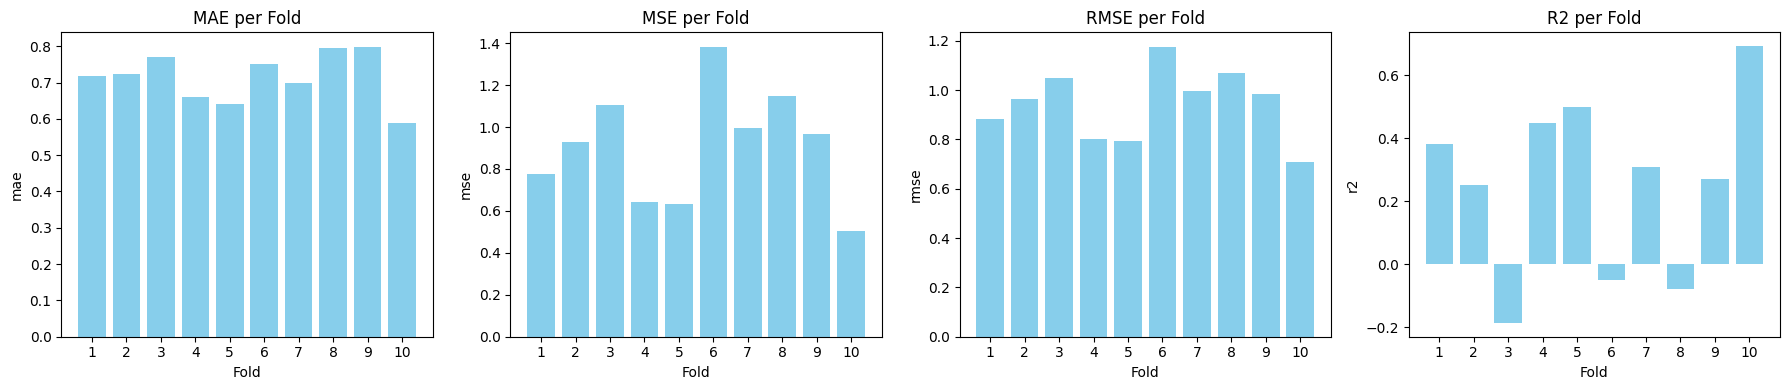

📊 Mean ± Std for Cross-Validation Metrics:


,mean,std
mae,0.7144,0.0689
mse,0.9084,0.2705
rmse,0.9433,0.1441
r2,0.2545,0.2802


In [11]:
# %%
import pandas as pd
import matplotlib.pyplot as plt

# Load summary
cv_path = os.path.join(results_dir, "crossval_summary.csv")
cv_df = pd.read_csv(cv_path)

# Choose metrics
task_metrics = (
    ['accuracy','precision','recall','f1_score','auc_roc']
    if task=="classification"
    else ['mae','mse','rmse','r2']
)

# Plot bar charts per fold
fig, axs = plt.subplots(1, len(task_metrics), figsize=(18, 4))
for i, metric in enumerate(task_metrics):
    axs[i].bar(cv_df['fold'], cv_df[metric], color='skyblue')
    axs[i].set_title(f"{metric.upper()} per Fold")
    axs[i].set_xlabel("Fold")
    axs[i].set_ylabel(metric)
    axs[i].set_xticks(cv_df['fold'])

plt.tight_layout()
plt.show()

# Display mean ± std
summary_stats = cv_df[task_metrics].agg(['mean','std']).T
print("📊 Mean ± Std for Cross-Validation Metrics:")
display(summary_stats.round(4))


## 8a: Ensemble Averaging from Cross-Validation Models

In [12]:
# Load test data
ensemble_preds = []
test_data = torch.load(os.path.join(base_path, f"{task}_test.pt"))
test_loader = DataLoader(test_data, batch_size=32)

# Ensure model configuration matches
output_dim = num_classes if task == "classification" else 1

# Collect predictions from each fold model
for fold in range(10):
    GIN(in_channels=train_data[0].x.size(1), hidden_channels=best_hidden_dim, out_channels=1, dropout=best_dropout).to(device)
    model.load_state_dict(torch.load(os.path.join(results_dir, f"fold{fold+1}_model.pt")))
    model.eval()
    fold_outputs = []
    with torch.no_grad():
        for batch in test_loader:
            batch = batch.to(device)
            out = model(batch)
            fold_outputs.append(out.cpu())
    ensemble_preds.append(torch.cat(fold_outputs, dim=0))

# Average predictions across folds
avg_output = torch.stack(ensemble_preds).mean(dim=0)

# Prepare final predictions and true labels
if task == "classification":
    final_pred = avg_output.argmax(dim=1).numpy()
    true_labels = torch.cat([data.y for data in test_data]).numpy().astype(int)
else:
    final_pred = avg_output.squeeze().numpy()
    true_value = torch.cat([data.y for data in test_data]).numpy()

print(f"✅ Ensemble predictions ready: shape {final_pred.shape}")

✅ Ensemble predictions ready: shape (53,)


## 8b: Ensemble Evaluation & Visualization


Ensemble: MAE=0.638, RMSE=0.872, R2=0.427


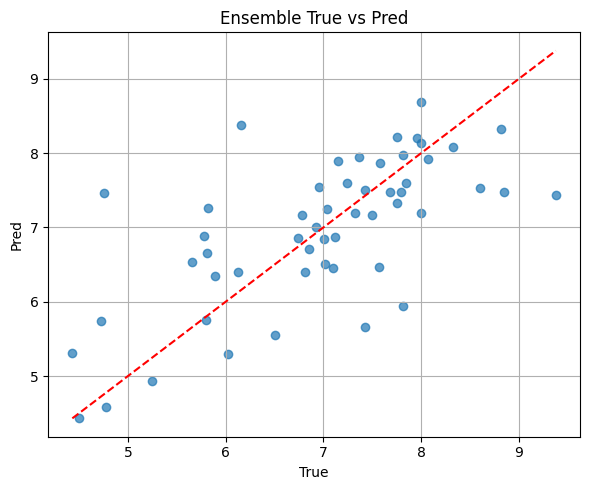

In [13]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
mae = mean_absolute_error(true_value, final_pred)
mse = mean_squared_error  (true_value, final_pred)
rmse= np.sqrt(mse)
r2  = r2_score           (true_value, final_pred)
print(f"Ensemble: MAE={mae:.3f}, RMSE={rmse:.3f}, R2={r2:.3f}")
plt.figure(figsize=(6,5)); plt.scatter(true_value,final_pred,alpha=0.7)
plt.plot([true_value.min(),true_value.max()],[true_value.min(),true_value.max()], 'r--'); plt.xlabel("True"); plt.ylabel("Pred"); plt.title("Ensemble True vs Pred"); plt.grid(True); plt.tight_layout(); plt.show()


## 9: Final Model Training on Combined Train+Val & Test Evaluation (Hold‑Out Test)

In [14]:
# %%
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import pandas as pd
import matplotlib.pyplot as plt

# 1) Merge all train+val folds
all_data = []
for fold in range(10):
    all_data += torch.load(os.path.join(base_path, f"{task}_train_fold{fold}.pt"))
    all_data += torch.load(os.path.join(base_path, f"{task}_val_fold{fold}.pt"))

# 2) Reserve a small val split for early stopping
tidx, vidx = train_test_split(
    list(range(len(all_data))),
    test_size=0.10,
    random_state=seed,
    shuffle=True
)
train_split = [all_data[i] for i in tidx]
val_split   = [all_data[i] for i in vidx]

train_loader = DataLoader(train_split, batch_size=32, shuffle=True)
val_loader   = DataLoader(val_split,   batch_size=32)

# 3) Instantiate & train final model
model     = GIN(train_data[0].x.size(1),
                 hidden_channels=best_hidden_dim,
                 out_channels=output_dim,
                 dropout=best_dropout).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=best_lr)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', patience=5, factor=0.5, verbose=True
)

best_val_loss = float('inf')
patience      = 0

for epoch in range(1, 300):
    model.train()
    total_loss = 0.0
    for batch in train_loader:
        batch = batch.to(device)
        optimizer.zero_grad()
        out = model(batch)
        loss = (F.cross_entropy(out, batch.y.long())
                if task == "classification"
                else F.mse_loss(out.squeeze(), batch.y))
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    # Validation for early stopping
    preds, targets = evaluate(model, val_loader)
    val_loss = (F.cross_entropy(preds, targets.long()).item()
                if task == "classification"
                else F.mse_loss(preds.squeeze(), targets).item())

    scheduler.step(val_loss)
    print(f"Epoch {epoch:03d} | Train Loss: {total_loss/len(train_loader):.4f} | Val Loss: {val_loss:.4f}")

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience      = 0
        torch.save(model.state_dict(), os.path.join(results_dir, "final_model.pt"))
    else:
        patience += 1
        if patience >= 10:
            print("⏹️ Early stopping")
            break

# 4) Load best final model & evaluate on ORIGINAL TEST set
model.load_state_dict(torch.load(os.path.join(results_dir, "final_model.pt")))
test_data   = torch.load(os.path.join(base_path, f"{task}_test.pt"))
test_loader = DataLoader(test_data, batch_size=32)

preds, targets = evaluate(model, test_loader)
pred_final     = (preds.argmax(dim=1).numpy() 
                  if task=="classification" 
                  else preds.squeeze().numpy())
true_final     = torch.cat([d.y for d in test_data]).numpy().astype(int if task=="classification" else float)

# 5) Compute final metrics
if task == "classification":
    from sklearn.metrics import (
        accuracy_score,
        precision_recall_fscore_support,
        roc_auc_score
    )
    acc       = accuracy_score(true_final, pred_final)
    precision, recall, f1, _ = precision_recall_fscore_support(
        true_final, pred_final, average="weighted", zero_division=0
    )
    probs     = F.softmax(preds, dim=1).cpu().numpy()
    auc       = roc_auc_score(
        label_binarize(true_final, classes=np.arange(num_classes)),
        probs, multi_class="ovr"
    )
    final_metrics = {
        "accuracy": acc, "precision": precision,
        "recall": recall, "f1_score": f1, "auc_roc": auc
    }
else:
    mae_f  = mean_absolute_error(true_final, pred_final)
    mse_f  = mean_squared_error(true_final, pred_final)
    rmse_f = np.sqrt(mse_f)
    r2_f   = r2_score(true_final, pred_final)
    final_metrics = {"mae": mae_f, "mse": mse_f, "rmse": rmse_f, "r2": r2_f}


c:\Users\MIchele Myong\anaconda3\envs\pytorch_env\Lib\site-packages\torch\optim\lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Epoch 001 | Train Loss: 8.2574 | Val Loss: 0.8456
Epoch 002 | Train Loss: 0.7803 | Val Loss: 0.6877
Epoch 003 | Train Loss: 0.6414 | Val Loss: 0.7009
Epoch 004 | Train Loss: 0.5896 | Val Loss: 0.4580
Epoch 005 | Train Loss: 0.4567 | Val Loss: 0.4487
Epoch 006 | Train Loss: 0.4017 | Val Loss: 0.4450
Epoch 007 | Train Loss: 0.3602 | Val Loss: 0.4009
Epoch 008 | Train Loss: 0.3142 | Val Loss: 0.2512
Epoch 009 | Train Loss: 0.3205 | Val Loss: 0.2848
Epoch 010 | Train Loss: 0.2656 | Val Loss: 0.2330
Epoch 011 | Train Loss: 0.2264 | Val Loss: 0.2007
Epoch 012 | Train Loss: 0.2117 | Val Loss: 0.2653
Epoch 013 | Train Loss: 0.2122 | Val Loss: 0.1819
Epoch 014 | Train Loss: 0.1983 | Val Loss: 0.1730
Epoch 015 | Train Loss: 0.1732 | Val Loss: 0.2608
Epoch 016 | Train Loss: 0.1797 | Val Loss: 0.2191
Epoch 017 | Train Loss: 0.1557 | Val Loss: 0.1464
Epoch 018 | Train Loss: 0.1460 | Val Loss: 0.1283
Epoch 019 | Train Loss: 0.1702 | Val Loss: 0.1515
Epoch 020 | Train Loss: 0.1529 | Val Loss: 0.2956


In [15]:
# Save final metrics to a CSV file
final_metrics_df = pd.DataFrame([final_metrics])
final_metrics_df.to_csv(os.path.join(results_dir, "final_metrics.csv"), index=False)

## 10. Generate plots and compare to ensemble

,metric,ensemble,final
0,mae,0.638483,0.653143
1,mse,0.761252,0.835509
2,rmse,0.872498,0.914062
3,r2,0.427084,0.371198


✅ Final model saved to GIN_results/regression_10fold/final_model.pt
✅ Ensemble plot saved to GIN_results/regression_10fold/ensemble_plot.png
✅ Final model plot saved to GIN_results/regression_10fold/final_model_plot.png


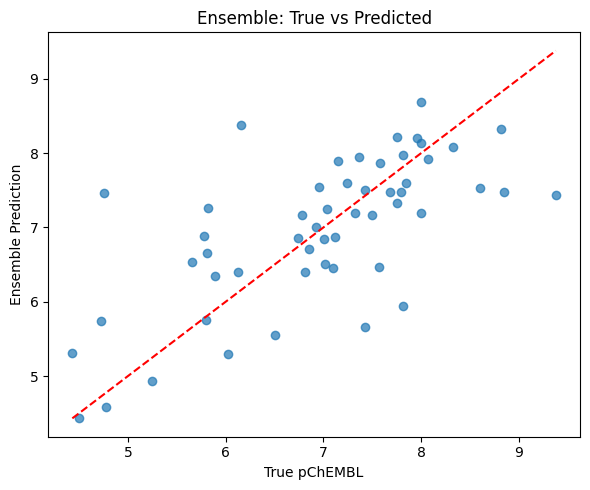

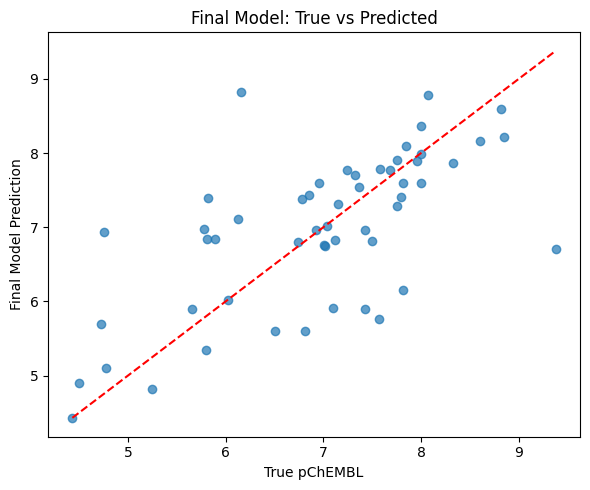

In [16]:
# Prepare ensemble metrics list
if task == "classification":
    ensemble_metrics = [acc, precision, recall, f1, auc]
else:
    ensemble_metrics = [mae, mse, rmse, r2]

# Create comparison DataFrame
comp = pd.DataFrame({
    "metric":   list(final_metrics.keys()),
    "ensemble": ensemble_metrics,
    "final":    list(final_metrics.values())
})
display(comp)


# 8) Save final model
model_path = os.path.join(results_dir, "final_model.pt")
torch.save(model.state_dict(), model_path)
print(f"✅ Final model saved to {model_path}")
#
ensemble_plot_path = os.path.join(results_dir, "ensemble_plot.png")
fig_ensemble, ax_ensemble = plt.subplots(figsize=(6, 5))
ax_ensemble.scatter(true_value, final_pred, alpha=0.7)
ax_ensemble.plot(
    [true_value.min(), true_value.max()],
    [true_value.min(), true_value.max()],
    'r--'
)
ax_ensemble.set_title("Ensemble: True vs Predicted")
ax_ensemble.set_xlabel("True pChEMBL")
ax_ensemble.set_ylabel("Ensemble Prediction")
plt.tight_layout()
fig_ensemble.savefig(ensemble_plot_path)
print(f"✅ Ensemble plot saved to {ensemble_plot_path}")

# Save final model plot
final_model_plot_path = os.path.join(results_dir, "final_model_plot.png")
fig_final, ax_final = plt.subplots(figsize=(6, 5))
ax_final.scatter(true_final, pred_final, alpha=0.7)
ax_final.plot(
    [true_final.min(), true_final.max()],
    [true_final.min(), true_final.max()],
    'r--'
)
ax_final.set_title("Final Model: True vs Predicted")
ax_final.set_xlabel("True pChEMBL")
ax_final.set_ylabel("Final Model Prediction")
plt.tight_layout()
fig_final.savefig(final_model_plot_path)
print(f"✅ Final model plot saved to {final_model_plot_path}")